# Getting started with RNNs

This notebook provides an illustration of how to implement RNNs in Keras

**TASKS**:
- Run the provided script and comment on the output.
- Vary the number and size of the LSTM layers and compare training time and performance.

**Important note**: Please try to use Python 3.6 for this task. The Keras implementation of LSTM has compatibility problems with Python 3.8. Alternatively, you can use Google Colab: https://colab.research.google.com/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
layers = keras.layers

from platform import python_version

print(python_version())


print(keras.__version__)

3.8.10
2.4.0


### Generation of data: sinusoidal signal time trace

We create a signal time trace: t = 0-100, f = sin(pi * t)

In [2]:
N = 10000
t = np.linspace(0, 100, N)  # time steps
f = np.sin(np.pi * t)  # signal

Split into semi-redundant sub-sequences of length = window_size + 1 and perform shuffle

In [3]:
window_size = 20
n = N - window_size - 1  # number of possible splits
data = np.stack([f[i: i + window_size + 1] for i in range(n)])

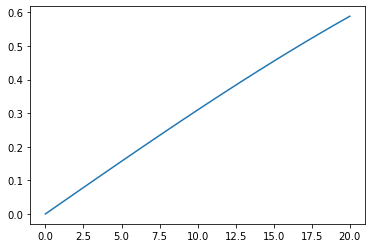

In [4]:
plt.plot(data[200])

Split the data into features

In [5]:
X, y = np.split(data, [-1], axis=1)
X = X[..., np.newaxis]

print('Example:')
print('X =', X[0, :, 0])
print('y =', y[0, :])

Example:
X = [0.         0.0314139  0.06279679 0.0941177  0.1253457  0.15644998
 0.18739983 0.21816471 0.24871423 0.27901826 0.30904688 0.33877044
 0.36815961 0.39718538 0.42581909 0.45403249 0.48179773 0.50908739
 0.53587454 0.56213275]
y = [0.58783609]


### Design and train a RNN

In [6]:
model = keras.Sequential()
model.add(layers.InputLayer(input_shape=(None, 1)))
model.add(layers.LSTM(16))
model.add(layers.Dense(1))
print(model.summary())

model.compile(loss='mse', optimizer='adam')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1152      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
results = model.fit(X, y,
    epochs=60,
    batch_size=32,
    verbose=2,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(factor=0.67, patience=3, verbose=1, min_lr=1E-5),
        keras.callbacks.EarlyStopping(patience=4, verbose=1)])

Epoch 1/60
281/281 - 2s - loss: 0.1781 - val_loss: 0.0029
Epoch 2/60
281/281 - 1s - loss: 0.0015 - val_loss: 6.9745e-04
Epoch 3/60
281/281 - 1s - loss: 4.3387e-04 - val_loss: 2.2450e-04
Epoch 4/60
281/281 - 1s - loss: 1.3181e-04 - val_loss: 6.7952e-05
Epoch 5/60
281/281 - 2s - loss: 4.1447e-05 - val_loss: 3.0478e-05
Epoch 6/60
281/281 - 2s - loss: 2.3541e-05 - val_loss: 2.2928e-05
Epoch 7/60

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0006700000318232924.
281/281 - 1s - loss: 1.7549e-05 - val_loss: 1.8946e-05
Epoch 8/60
281/281 - 1s - loss: 1.4431e-05 - val_loss: 1.2261e-05
Epoch 9/60
281/281 - 1s - loss: 1.2138e-05 - val_loss: 1.2444e-05
Epoch 10/60

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0004489000252215192.
281/281 - 1s - loss: 1.2155e-05 - val_loss: 1.0342e-05
Epoch 11/60
281/281 - 1s - loss: 1.0512e-05 - val_loss: 9.3014e-06
Epoch 12/60
281/281 - 1s - loss: 1.0073e-05 - val_loss: 9.2045e-06
Epoch 13/60

Epoch 00013: ReduceLROnPlateau reducing le

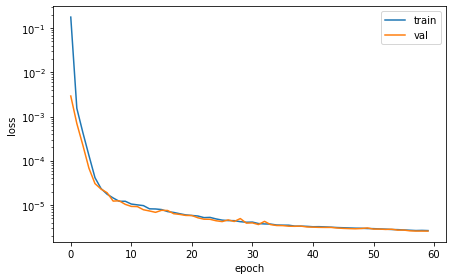

In [8]:
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.ylabel('loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.tight_layout()

### Evaluate the model's capability in forcasting

In [9]:
def predict_next_k(model, window, k=10):
    """Predict next k steps for the given model and starting sequence """
    x = window[np.newaxis, :, np.newaxis]  # initial input
    y = np.zeros(k)
    for i in range(k):
        y[i] = model.predict(x, verbose=0)
        # create the new input including the last prediction
        x = np.roll(x, -1, axis=1)  # shift all inputs 1 step to the left
        x[:, -1] = y[i]  # add latest prediction to end
    return y

In [10]:
def plot_prediction(i0=0, k=500):
    """ Predict and plot the next k steps for an input starting at i0 """
    y0 = f[i0: i0 + window_size]  # starting window (input)
    y1 = predict_next_k(model, y0, k)  # predict next k steps

    t0 = t[i0: i0 + window_size]
    t1 = t[i0 + window_size: i0 + window_size + k]

    plt.figure(figsize=(12, 4))
    plt.plot(t, f, label='data')
    plt.plot(t0, y0, color='C1', lw=3, label='prediction')
    plt.plot(t1, y1, color='C1', ls='--')
    plt.xlim(0, 10)
    plt.legend()
    plt.xlabel('$t$')
    plt.ylabel('$f(t)$')

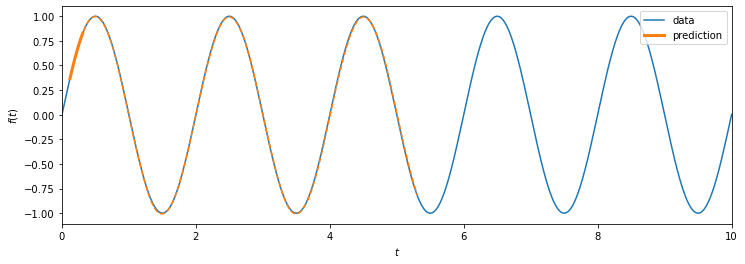

In [11]:
plot_prediction(12)